In [7]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

## EDA

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from db.mongo import claims_col, policies_col, vehicles_col

In [11]:
claims = list(claims_col.find({}))
df_claims = pd.DataFrame(claims)

df_claims.head()

,_id,policy_id,claim_amount,claim_type,submitted_at,status,fraud_score,ml_score,rule_score
0,CLM0001,POL009,722748,Accident,2024-09-22 18:25:20,under_review,0,0,0
1,CLM0002,POL008,978247,Theft,2024-05-13 04:15:06,under_review,10,0,10
2,CLM0003,POL003,694922,Fire,2023-12-17 01:17:56,under_review,10,0,10
3,CLM0004,POL011,816501,Theft,2024-12-27 18:51:32,under_review,30,0,30
4,CLM0005,POL011,622096,Theft,2024-12-27 20:53:19,under_review,30,0,30


In [12]:
df_claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   _id           100 non-null    object        
 1   policy_id     100 non-null    object        
 2   claim_amount  100 non-null    int64         
 3   claim_type    100 non-null    object        
 4   submitted_at  100 non-null    datetime64[ns]
 5   status        100 non-null    object        
 6   fraud_score   100 non-null    int64         
 7   ml_score      100 non-null    int64         
 8   rule_score    100 non-null    int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 7.2+ KB


In [13]:
df_claims.describe()

,claim_amount,submitted_at,fraud_score,ml_score,rule_score
count,1.000000e+02,100,100.000000,100.000000,100.000000
mean,1.036071e+06,2024-06-24 20:15:22.299999744,14.000000,3.000000,11.200000
min,2.760230e+05,2023-02-02 10:49:48,0.000000,0.000000,0.000000
25%,6.716042e+05,2024-03-31 14:12:43.249999872,0.000000,0.000000,0.000000
50%,8.888175e+05,2024-07-27 06:59:31.500000,0.000000,0.000000,0.000000
75%,1.360413e+06,2024-11-08 18:07:56.249999872,10.000000,0.000000,10.000000
max,2.311624e+06,2024-12-31 23:48:14,100.000000,50.000000,70.000000
std,4.990178e+05,NaN,23.825968,11.934163,17.013364


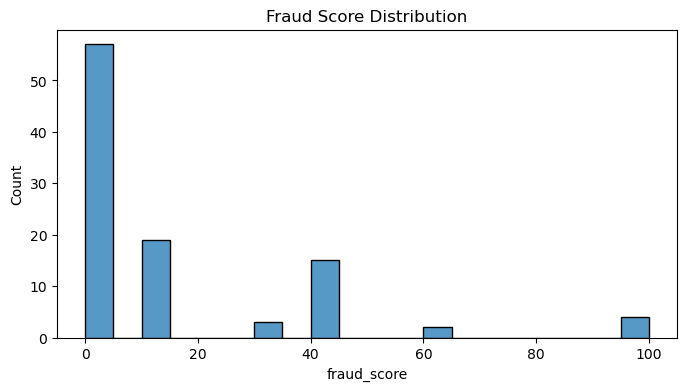

In [15]:
plt.figure(figsize=(8,4))
sns.histplot(df_claims["fraud_score"], bins=20)
plt.title("Fraud Score Distribution")
plt.show()

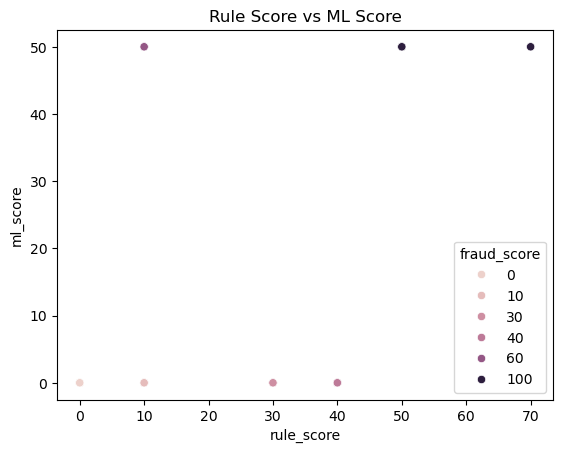

In [16]:
sns.scatterplot(data=df_claims, x="rule_score", y="ml_score", hue="fraud_score")
plt.title("Rule Score vs ML Score")
plt.show()

## Feature Engineering
Loading & Merging Claim, Policy and vehicle Data for context

In [17]:
claims = list(claims_col.find({}))
policies = {p["_id"]: p for p in policies_col.find({})}
vehicles = {v["_id"]: v for v in vehicles_col.find({})}

df = pd.DataFrame(claims)

In [18]:
def build_features(row):
    policy = policies[row["policy_id"]]
    vehicle = vehicles[policy["vehicle_id"]]

    return {
        "claim_amount": row["claim_amount"],
        "vehicle_value": vehicle["estimated_value"],
        "claim_to_value_ratio": row["claim_amount"] / vehicle["estimated_value"],
        "days_since_policy_start": (
            row["submitted_at"] - policy["start_date"]
        ).days
    }

features = pd.DataFrame(df.apply(build_features, axis=1).tolist())
features.head()

,claim_amount,vehicle_value,claim_to_value_ratio,days_since_policy_start
0,722748,842679,0.857679,575
1,978247,874660,1.118431,452
2,694922,1179804,0.589015,193
3,816501,621477,1.313807,0
4,622096,621477,1.000996,0


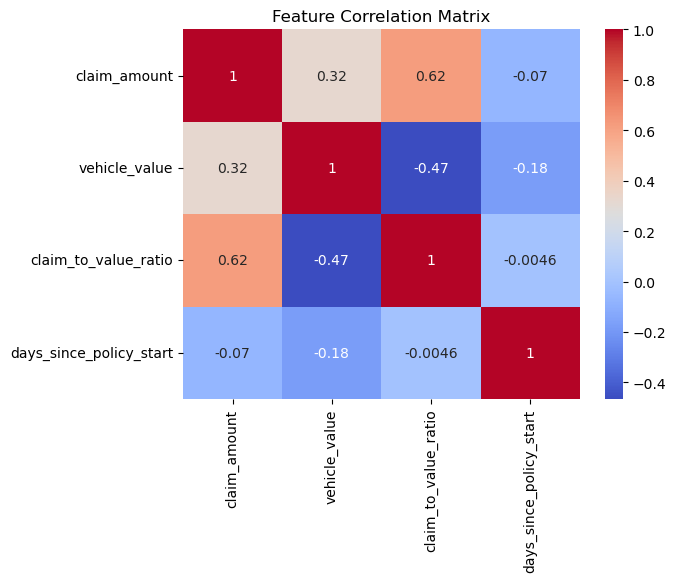

In [19]:
sns.heatmap(features.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

## Model Training & Evaluation
Using Anomaly Detection to train and evaluate fraud models without labels.

In [20]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [21]:
X = features.copy()

pipeline = Pipeline([
    ("scaler", StandardScaler()), # important for distance-based methods
    ("model", IsolationForest(
        n_estimators=200,
        contamination=0.1, # reflects expected fraud rate
        random_state=42
    ))
])

In [22]:
pipeline.fit(X)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 IsolationForest(contamination=0.1, n_estimators=200,
                                 random_state=42))])

In [23]:
preds = pipeline.predict(X)
df["ml_prediction"] = preds

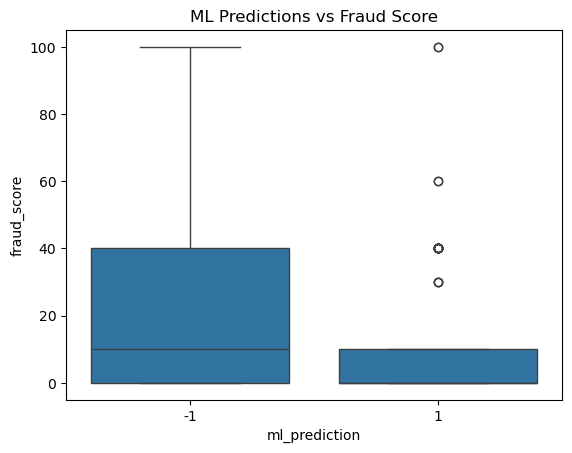

In [24]:
sns.boxplot(x=df["ml_prediction"], y=df["fraud_score"])
plt.title("ML Predictions vs Fraud Score")
plt.show()